In [3]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np 
from scipy.interpolate import interp2d, RegularGridInterpolator
import skimage.color as color

In [52]:
# Loading and analyzing the image

im1 = io.imread('/Users/richamishra/Documents/CompPhoto/assgn1/data/campus.tiff')
h, w = im1.shape
print(im1.shape), print(im1.dtype)
im2 = im1.copy().astype(np.float32)

(4016, 6016)
uint16


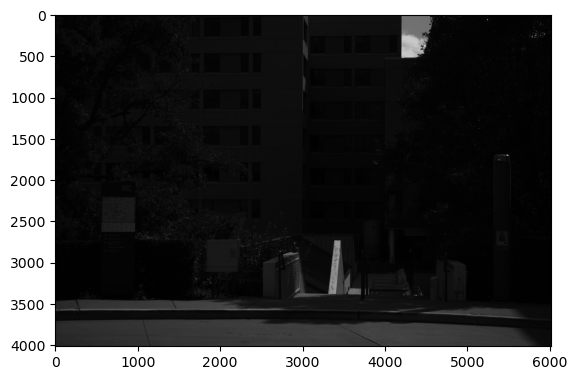

In [53]:
black = 150
white = 4095

im2 = (im2-black)/(white-black)
im2 = np.clip(im2,0,1)
plt.imshow(im2, cmap='gray')
#plt.imsave('/Users/richamishra/Documents/CompPhoto/assgn1/data/linear.png', im2, cmap='gray')

In [81]:
#White-world and gray-world white balance

# White balancing; white and gray
# rgbg: 2.394531 1.000000 1.597656 1.000000

# [[red, green],
# [green, blue]]

def white_gray_balance(im2):

    im2_gw = im2.copy()
    im2_ww = im2.copy()
    im2_preset = im2.copy()
    
    red = blue = green = 0
    r_max = g_max = b_max = 0
    
    for r in range(0,4016, 2):
        for c in range(0, 6016, 2):
    
            red += im2[r,c]
            green += im2[r,c+1]
            green += im2[r+1,c]
            blue += im2[r+1,c+1]
    
            r_max = max(r_max, im2[r,c])
            g_max = max(g_max, im2[r,c+1], im2[r+1,c])
            b_max = max(b_max, im2[r+1,c+1])

    red_gw = red/(2008*3008)
    green_gw = green/(4016*3008)
    blue_gw = blue/(2008*3008)
    
    for r in range(0,4016, 2):
        for c in range(0, 6016, 2):
    
            im2_gw[r,c] *= green_gw/red_gw
            im2_preset[r,c] *= 2.394531
            im2_gw[r+1,c+1] *= green_gw/blue_gw
            im2_preset[r+1,c+1] *= 1.597656


    for r in range(0,4016, 2):
        for c in range(0, 6016, 2):

            im2_ww[r,c] *= g_max/r_max
            im2_ww[r+1,c+1] *= g_max/b_max

    return im2_gw, im2_ww, im2_preset

def demosaic(im2_ww):

    y, x = np.meshgrid(np.arange(4016), np.arange(6016), indexing='ij')

    yr = np.arange(0, 4016, 2)
    xr = np.arange(0, 6016, 2)
    yyr, xxr = np.meshgrid(yr, xr, indexing='ij')
    zr = im2_ww[yyr, xxr]
    
    r = RegularGridInterpolator((yr, xr), zr, bounds_error=False)
    r_c = r((y, x))
    
    red = np.zeros_like(im2_ww)
    red[0::2, 0::2] = 1
    
    
    r_channel = im2_ww*red + r_c*(1-red)

    yb = np.arange(1, 4016, 2)
    xb = np.arange(1, 6016, 2)
    yyb, xxb = np.meshgrid(yb, xb, indexing='ij')
    zb = im2_ww[yyb, xxb]
    
    b = RegularGridInterpolator((yb, xb), zb, bounds_error=False)
    b_c = b((y, x))
    
    blue_mask = np.zeros_like(im2_ww)
    blue_mask[1::2, 1::2] = 1
    
    
    b_channel = im2_ww*blue_mask+ b_c*(1-blue_mask)

    yg1 = np.arange(0, 4016, 2)
    xg1 = np.arange(1, 6016, 2)
    
    yg2 = np.arange(1, 4016, 2)
    xg2 = np.arange(0, 6016, 2)
    
    yyg1, xxg1 = np.meshgrid(yg1, xg1, indexing='ij')
    yyg2, xxg2 = np.meshgrid(yg2, xg2, indexing='ij')
    
    zg1 = im2_ww[yyg1, xxg1]
    zg2 = im2_ww[yyg2, xxg2]
    
    
    g1 = RegularGridInterpolator((yg1, xg1), zg1, bounds_error=False)
    g2 = RegularGridInterpolator((yg2, xg2), zg2, bounds_error=False)
    g_c1 = g1((y, x))
    g_c2 = g2((y, x))
    
    green_mask1 = green_mask2 = np.zeros_like(im2_ww)
    green_mask1[0::2, 1::2] = 1
    green_mask2[1::2, 0::2] = 1
    
    
    g_channel = im2_ww*green_mask1 + g_c1*(1-green_mask1)
    g_channel += im2_ww*green_mask2 + g_c2*(1-green_mask2)
    g_channel /= 2

    demosaic = np.stack([r_channel, g_channel, b_channel], axis=2)
    return demosaic

def color_correct(demosaic):
    mat_srgb_xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
                              [0.2126729, 0.7151522, 0.0721750],
                              [0.0193339, 0.1191920, 0.9503041]])
    mat_xyz_cam = np.array([6988,-1384,-714,-5631,13410,2447,-1485,2204,7318]).reshape((3,3))/10000

    mat_srgb_cam = mat_xyz_cam@mat_srgb_xyz
    mat_srgb_cam_norm = mat_srgb_cam/np.sum(mat_srgb_cam, axis=0, keepdims=True)
    print(mat_srgb_cam_norm)

    demosaic = np.clip(demosaic, 0, 1)
    clr = demosaic@np.linalg.inv(mat_srgb_cam_norm)

    return clr

def gamma_encoding(clr):

    gamma_encoding = lambda x: np.where(x <= 0.0031308, 12.92*x, 1.055*x**(1/2.4)-0.055)
    img_tone = gamma_encoding(np.clip(clr*3.45,0,1))

    return img_tone

In [47]:
im2_gw, im2_ww, im2_preset = white_gray_balance(im2)

In [54]:
plt.imsave('../data/im2_ww.png', im2_ww, cmap='gray')
plt.imsave('../data/im2_gw.png', im2_gw, cmap='gray')
plt.imsave('../data/im2_preset.png', im2_preset, cmap='gray')

In [55]:
demosaic2 = demosaic(im2_ww)
plt.imsave('../data/demosaic_ww.png', demosaic2, cmap='gray')
clr2 = color_correct(demosaic2)
img_tone2 = gamma_encoding(clr2)

img_compressed = (np.clip(img_tone2, 0, 1)*255).astype(np.uint8)
io.imsave('campus_precessed_ww.png', img_compressed)

/Users/richamishra/miniconda3/envs/cp/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


In [56]:
demosaic1 = demosaic(im2_gw)
plt.imsave('../data/demosaic_gw.png', demosaic1, cmap='gray')
clr = color_correct(demosaic1)
img_tone = gamma_encoding(clr)

img_compressed = (np.clip(img_tone, 0, 1)*255).astype(np.uint8)
io.imsave('campus_precessed_gw.png', img_compressed)

In [57]:
demosaic2 = demosaic(im2_preset)
plt.imsave('../data/demosaic_pre.png', demosaic2, cmap='gray')
clr2 = color_correct(demosaic12)
img_tone = gamma_encoding(clr2)

img_compressed = (np.clip(img_tone, 0, 1)*255).astype(np.uint8)
io.imsave('campus_precessed_gw_preset.png', img_compressed)

/Users/richamishra/miniconda3/envs/cp/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


In [75]:
im = io.imread('/Users/richamishra/Documents/CompPhoto/assgn1/data/campus.jpg')
mask1 = np.zeros_like(im)

mask1[0:100,4300:4400,:] = 1
im_masked = im*mask1 + (1-mask1)*im/1000

plt.imsave('../data/mask1.jpeg', np.clip(im_masked, 0, 1))

mask2 = np.zeros_like(im)

mask2[2800:2900,3400:3440,:] = 1
im_masked = im*mask2 + (1-mask2)*im/1000

plt.imsave('../data/mask2.jpeg', np.clip(im_masked,0,1))

In [78]:
#x_max, x_min, y_max, y_min = 4400, 4300, 100, 0
x_max, x_min, y_max, y_min = 3440, 3400, 2900, 2800

r = np.mean(im2[int(y_min):int(y_max):2, int(x_min):int(x_max):2])
b = np.mean(im2[int(y_min)+1:int(y_max):2, int(x_min)+1:int(x_max):2])
g1 = np.mean(im2[int(y_min):int(y_max):2, int(x_min)+1:int(x_max):2])
g2 = np.mean(im2[int(y_min)+1:int(y_max):2, int(x_min):int(x_max):2])
g = (g1+g2)/2
print(r,g,b)

im2_mww1 = im2.copy()

im2_mww1[0::2, 0::2] /= r
im2_mww1[1::2, 1::2] /= b
im2_mww1[0::2, 1::2] /= g
im2_mww1[1::2, 0::2] /= g

0.2781498 0.7035448551177979 0.45641065


In [82]:
demosaic1 = demosaic(im2_mww1)
clr = color_correct(demosaic1)
img_tone = gamma_encoding(clr)

img_compressed = (np.clip(img_tone, 0, 1)*255).astype(np.uint8)
io.imsave('../data/campus_precessed_mww2.png', img_compressed)

[[ 8.17556106e-01  1.27021601e-01  5.02323845e-02]
 [ 1.83168423e-01  7.01925645e-01  2.37082788e-01]
 [-7.24528810e-04  1.71052754e-01  7.12684827e-01]]


/var/folders/_q/d0ww93zs26b5hx__yj4hc21r0000gn/T/ipykernel_91688/701867124.py:5: RuntimeWarning: invalid value encountered in cast
  img_compressed = (np.clip(img_tone, 0, 1)*255).astype(np.uint8)
